<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/image/ambulanze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import re
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Advanced audio features
import librosa.display
from sklearn.preprocessing import scale

In [33]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/ambulanze/"

Mounted at /content/gdrive


In [3]:
trainAV = pd.read_csv("gdrive/MyDrive/train.csv")
testAV = pd.read_csv("gdrive/MyDrive/test_vc2kHdQ.csv")

In [4]:
print(len(trainAV) + len(testAV))

7290


In [5]:
trainAV.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
def add_class():
  for i, f in enumerate(sorted(os.listdir(base_dir))):
    if f.endswith('.jpg'):
      name = re.search(r'^(\d+)\.jpg$', f).group(1)

      a = plt.imread(base_dir + f)      
      fig = plt.figure(figsize=(4,4))
      ax = fig.add_subplot(111)

      ax.imshow(a)

      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.set_frame_on(False)

      if f in trainAV['image_names'].values:
        label = trainAV.loc[trainAV['image_names'] == f]['emergency_or_not'].values[0] 

      elif f in testAV['image_names'].values:
        label = 2

      if int(label) == 0:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)

      elif int(label) == 1:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)

      elif int(label) == 2:
          fig.savefig("gdrive/MyDrive/emergency_models/class_test/{}.jpg".format(name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)
    plt.close("all")
    print("Completato il: ", round(i/7290*100,2), "% dei file")

In [7]:
add_class()

Output streaming troncato alle ultime 5000 righe.
Completato il:  31.43 % dei file
Completato il:  31.44 % dei file
Completato il:  31.45 % dei file
Completato il:  31.47 % dei file
Completato il:  31.48 % dei file
Completato il:  31.5 % dei file
Completato il:  31.51 % dei file
Completato il:  31.52 % dei file
Completato il:  31.54 % dei file
Completato il:  31.55 % dei file
Completato il:  31.56 % dei file
Completato il:  31.58 % dei file
Completato il:  31.59 % dei file
Completato il:  31.6 % dei file
Completato il:  31.62 % dei file
Completato il:  31.63 % dei file
Completato il:  31.65 % dei file
Completato il:  31.66 % dei file
Completato il:  31.67 % dei file
Completato il:  31.69 % dei file
Completato il:  31.7 % dei file
Completato il:  31.71 % dei file
Completato il:  31.73 % dei file
Completato il:  31.74 % dei file
Completato il:  31.76 % dei file
Completato il:  31.77 % dei file
Completato il:  31.78 % dei file
Completato il:  31.8 % dei file
Completato il:  31.81 % dei fi

Ora che abbiamo il vettore di label bisogna separare le immagini in due sotto directory in modo che siano facilmente importabili con tensorflow

In [21]:
!pip install split-folders

In [34]:
import splitfolders
splitfolders.ratio("gdrive/MyDrive/emergency_models", output="gdrive/MyDrive/emergency_true_models", ratio=(0.6, 0.3, 0.1))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  1.31 files/s]
Copying files: 12 files [00:00,  1.86 files/s]
Copying files: 23 files [00:01,  2.60 files/s]
Copying files: 32 files [00:01,  3.57 files/s]
Copying files: 48 files [00:01,  5.01 files/s]
Copying files: 62 files [00:01,  7.05 files/s]
Copying files: 70 files [00:01,  9.60 files/s]
Copying files: 83 files [00:02, 13.02 files/s]
Copying files: 98 files [00:02, 17.93 files/s]
Copying files: 108 files [00:02, 22.99 files/s]
Copying files: 117 files [00:02, 28.04 files/s]
Copying files: 133 files [00:02, 37.25 files/s]
Copying files: 144 files [00:02, 43.07 files/s]
Copying files: 154 files [00:02, 46.30 files/s]
Copying files: 165 files [00:03, 50.51 files/s]
Copying files: 179 files [00:03, 62.41 files/s]
Copying files: 189 files [00:03, 64.55 files/s]
Copying files: 198 files [00:03, 61.00 files/s]
Copying files: 211 files [00:03, 63.91 files/s]
Copying files: 226 files [00:03, 77.16 files/s]
Copying

# Modelli

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception

In [45]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = xception.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)

x_train, y_train = next(train_generator)

Found 3950 images belonging to 2 classes.


In [46]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)
x_validation, y_validation = next(validation_generator)

Found 1975 images belonging to 2 classes.


In [47]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)
x_test, y_test = next(test_generator)

Found 659 images belonging to 2 classes.


In [48]:
from tensorflow.keras.applications import xception
base_net = xception.Xception(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')

In [49]:
for layer in base_net.layers:
    layer.trainable = False

In [50]:
x = base_net.output

x = keras.layers.Dense(64, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [51]:
net1 = keras.Model(inputs = base_net.input, outputs = pred)

In [52]:
net1.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.Adam(),
           metrics = ['accuracy'])

In [53]:
hist1 = net1.fit(train_generator,
       epochs = 5,
       validation_data = validation_generator)

Epoch 1/5
124/124 [==============================] - 29s 212ms/step - loss: 0.3022 - accuracy: 0.8664 - val_loss: 0.2076 - val_accuracy: 0.9175
Epoch 2/5
124/124 [==============================] - 25s 199ms/step - loss: 0.1677 - accuracy: 0.9366 - val_loss: 0.1829 - val_accuracy: 0.9251
Epoch 3/5
124/124 [==============================] - 24s 197ms/step - loss: 0.1358 - accuracy: 0.9524 - val_loss: 0.1888 - val_accuracy: 0.9251
Epoch 4/5
124/124 [==============================] - 24s 198ms/step - loss: 0.1377 - accuracy: 0.9501 - val_loss: 0.1594 - val_accuracy: 0.9372
Epoch 5/5
124/124 [==============================] - 24s 197ms/step - loss: 0.1071 - accuracy: 0.9619 - val_loss: 0.1698 - val_accuracy: 0.9311


In [54]:
def acc_loss(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Validation loss", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15) 
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label = "Train accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15) 

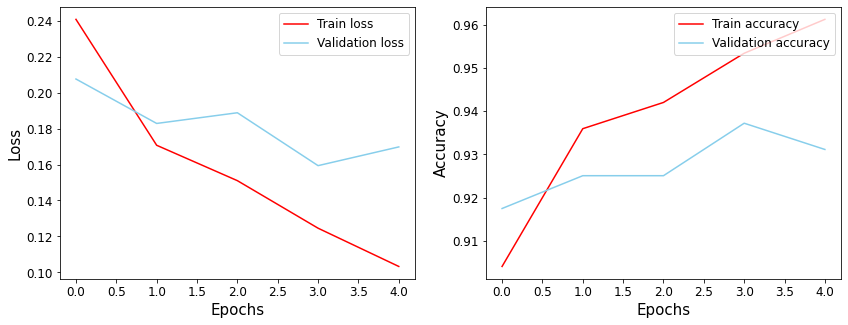

In [55]:
acc_loss(hist1)

In [56]:
acc1 = net1.evaluate(test_generator)

21/21 [==============================] - 3s 136ms/step - loss: 0.1280 - accuracy: 0.9499


In [57]:
pred_1 = net1.predict(test_generator)

In [58]:
pred_1 = np.argmax(pred_1, axis = 1)

In [59]:
print(classification_report(test_generator.classes, pred_1))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       386
           1       0.92      0.97      0.94       273

    accuracy                           0.95       659
   macro avg       0.95      0.95      0.95       659
weighted avg       0.95      0.95      0.95       659



Text(0.5, 1.0, 'Confusion matrix')

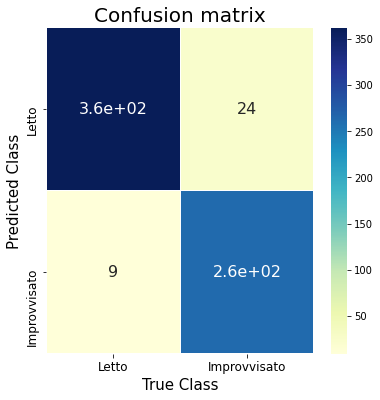

In [60]:
cm = confusion_matrix(test_generator.classes, pred_1)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 
#ax.set_yticklabels(['Letto', 'Improvvisato'], rotation=90, ha='right', minor=False)

plt.title("Confusion matrix", size = 20)